# Glycocalyx - Divalent Salt Interface Simulation


## 1. Steady State Equations

### 1.1 Salt Layer

The equation for the gel layer is a non-linear 2nd order ordinary differential equation.

$$ \frac{d^2\phi_D(x)}{dx^2} = \frac{c_{i,o}}{c_{j,o}} \left( e^{\phi_D(x)}-e^{-2\phi_D(x)} \right) $$


### 1.2 Gel Layer

The equation for the gel layer is a non-linear 2nd order ordinary differential equation.

$$ \frac{d^2y}{dx^2} = S\left( e^{y}-e^{-2y} \right) + \frac{\left( -1- \frac{P_1c_{i,0}e^{-y}}{2} + \left[(1+\frac{P_1c_{i,0}e^{-y}}{2})^2 + 4P_1P_2c_{j,0}c_{i_0}e^{-y}\right]^{\frac{1}{2}} \right)}{2P_1P_2c_{j,0}c_{i,0}e^{-y}} $$




## 2. Steady State Simulation
### 2.1 'Jump' Conditions
Determine the value at $y(x \rightarrow \infty)$ using function solver

In [6]:
# --------------------------
# import libraries
# --------------------------
import numpy as np
from scipy.integrate import solve_bvp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# --------------------------
# define and determine constants
# --------------------------
# initialize constants selected to match the Matlab code
c_g = .1
S = 0.1 # screening (c_i,o / c_j,o)
P1 = 0.1 # pairing   (c_i,o / K_ij)
P2 = 0.1 # secondary reaction constant

# calculate y(x->inf) assuming y''(x->inf)=0
def phi(y):
    c_a0 = S*c_g # concentration of anion in salt
    c_c0 = c_a0/2 # concentration of cation in salt
    def alpha(S, P1, P2, y):
        return 2*c_c0*np.exp(-y)*P1*P2
    def beta(S, P1, P2, y):
        return 1 + c_c0*np.exp(-y)*P1
    def free(y):
        return c_a0*(-np.exp(y)+np.exp(-2*y))
    def gel(y):
        a = alpha(S, P1, P2, y)
        b = beta(S, P1, P2, y)
        return (-free(y) + (-b + (b**2 + 4*c_g*a)**(0.5))/(2*a))/c_g
    return gel(y)

y_inf = fsolve(phi,-2)[0]
print(y_inf)

-1.1658448320730617


### 2.2 Optimization of Intercept
Run code to find intercept such that the slopes of the salt layer and gel layer are matched.

In [7]:
# --------------------------
# Loop through potential intercepts
# and optimize for minimum difference in slope at interface
# --------------------------
min_d_slope = 100 # minimum difference in slope
min_intercept = 0 # intercept associated with min_d_slope
dx= 0.05
testrange = np.arange(-10, 10 + dx, dx)
for y0 in np.arange(0, y_inf, -0.001):
    # SALT LAYER
    # --------------------------
    def fun_s(x, y):
        z  = y[1]
        c_a0 = S*c_g # concentration of anion in salt
        c_c0 = c_a0/2 # concentration of cation in salt
        def free(y):
            return c_a0*(-np.exp(y)+np.exp(-2*y))
        def gel(y):
            return (-free(y))/c_g
        dz = gel(y[0])
        return np.vstack((z, dz))

    def bc_s(ya, yb):
        return np.array([ya[0]-y0, yb[0]])

    xs = np.arange(0, 10+dx, dx)
    ys = -np.ones((2, xs.size))
    res = solve_bvp(fun_s, bc_s, xs, ys)
    ys = res.sol(xs)[0]
    slope_salt = (ys[1]-ys[0]) / (xs[1]-xs[0])
    
    # GEL LAYER
    # --------------------------
    def fun_g(x, y):
        z  = y[1]
        c_a0 = S*c_g # concentration of anion in salt
        c_c0 = c_a0/2 # concentration of cation in salt
        def alpha(S, P1, P2, y):
            return 2*c_c0*np.exp(-y)*P1*P2
        def beta(S, P1, P2, y):
            return 1 + c_c0*np.exp(-y)*P1
        def free(y):
            return c_a0*(-np.exp(y)+np.exp(-2*y))
        def gel(y):
            a = alpha(S, P1, P2, y)
            b = beta(S, P1, P2, y)
            return (-free(y) + (-b + (b**2 + 4*c_g*a)**(0.5))/(2*a))/c_g
        dz = gel(y[0])
        return np.vstack((z, dz))

    def bc_g(ya, yb):
        return np.array([yb[0]-y0, ya[0] - y_inf])

    x = np.arange(-10, 0+dx, dx)
    y = -np.ones((2, x.size))
    res = solve_bvp(fun_g, bc_g, x, y)
    y = res.sol(x)[0]
    slope_gel = (y[-1]-y[-2]) / (x[-1]-x[-2])
    
    # OPTIMIZATION
    # --------------------------
    d_slope = abs(slope_salt-slope_gel)
    if d_slope <= min_d_slope:
        min_d_slope = d_slope
        min_intercept = y0
        

print(min_d_slope, min_intercept)

0.00055835767767759 -0.767


### 2.3 Re-solve and Plot at Optimal Intercept

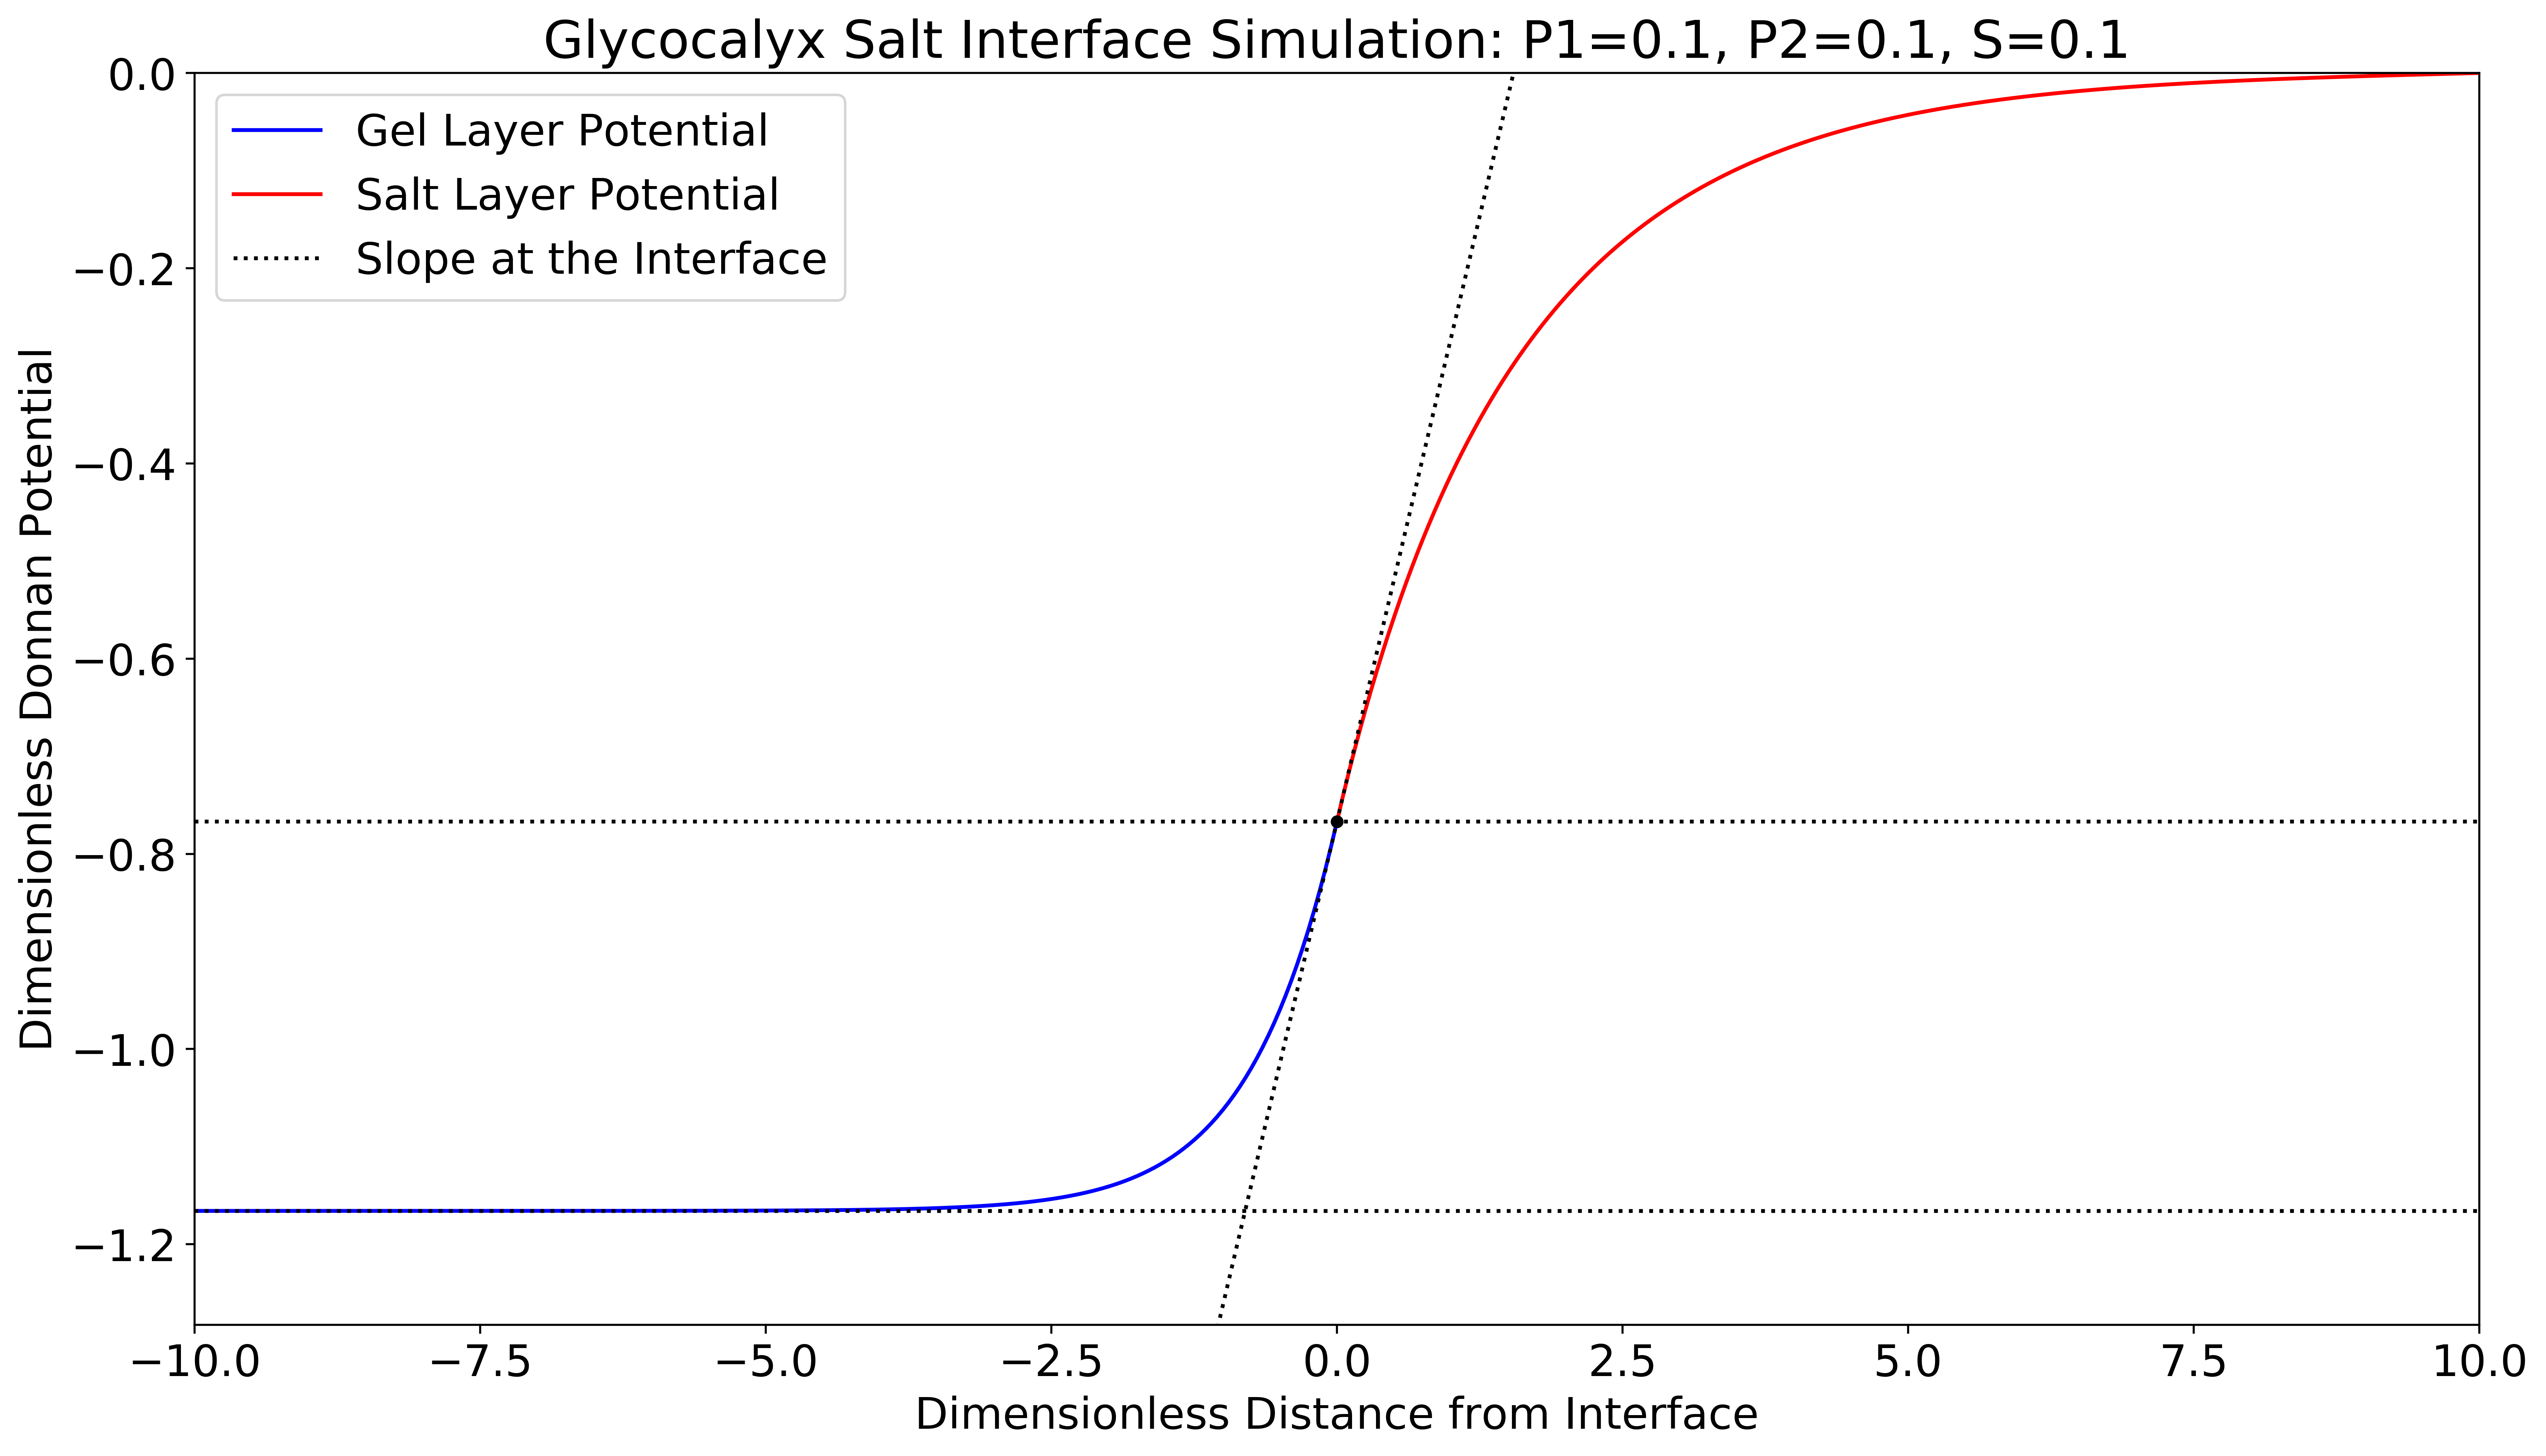

In [8]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
%matplotlib inline

dx = 0.05
y0 = min_intercept

# SALT LAYER
# --------------------------
def fun_s(x, y):
    z  = y[1]
    c_a0 = S*c_g # concentration of anion in salt
    c_c0 = c_a0/2 # concentration of cation in salt
    def free(y):
        return c_a0*(-np.exp(y)+np.exp(-2*y))
    def gel(y):
        return (-free(y))/c_g
    dz = gel(y[0])
    return np.vstack((z, dz))

def bc_s(ya, yb):
    return np.array([ya[0]-y0, yb[0]])

xs = np.arange(0, 10+dx, dx)
ys = -np.ones((2, xs.size))
res = solve_bvp(fun_s, bc_s, xs, ys)
ys = res.sol(xs)[0]

# TANGENT LINE
# --------------------------
xi = np.linspace(-2, 2, num=2)
slope = (ys[1]-ys[0]) / (xs[1]-xs[0])
yi = slope*xi+y0


# GEL LAYER
# -------------------------
# Solve the differential equation
def fun_g(x, y):
    z  = y[1]
    c_a0 = S*c_g # concentration of anion in salt
    c_c0 = c_a0/2 # concentration of cation in salt
    def alpha(S, P1, P2, y):
        return 2*c_c0*np.exp(-y)*P1*P2
    def beta(S, P1, P2, y):
        return 1 + c_c0*np.exp(-y)*P1
    def free(y):
        return c_a0*(-np.exp(y)+np.exp(-2*y))
    def gel(y):
        a = alpha(S, P1, P2, y)
        b = beta(S, P1, P2, y)
        return (-free(y) + (-b + (b**2 + 4*c_g*a)**(0.5))/(2*a))/c_g
    dz = gel(y[0])
    return np.vstack((z, dz))

def bc_g(ya, yb):
    return np.array([yb[0]-y0, ya[0] - y_inf])

x = np.arange(-10, 0 + dx, dx)
y = -np.ones((2, x.size))
res = solve_bvp(fun_g, bc_g, x, y)
y = res.sol(x)[0]

# PLOT RESULTS
# --------------------------
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(16,9), dpi=500)
plt.plot(x, y, 'b', label = 'Gel Layer Potential')
plt.plot(xs, ys, 'r', label = 'Salt Layer Potential')
plt.plot(xi, yi, 'k:', label = 'Slope at the Interface')
plt.plot(0, y0, 'ko', ms=4) # marker at intercept
plt.plot([x[0], xs[-1]], [y0, y0], 'k:') # marker at intercept
plt.plot([x[0], xs[-1]], [y_inf, y_inf], 'k:')

plt.title('Glycocalyx Salt Interface Simulation: P1='+ str(P1) + ', P2=' + str(P2) + ', S=' + str(S))
plt.xlabel('Dimensionless Distance from Interface')
plt.ylabel('Dimensionless Donnan Potential')
plt.legend()
plt.xlim(x[0], xs[-1])
plt.ylim(np.min(np.hstack((y, ys)))*1.1, np.max(np.hstack((y,ys))))
plt.savefig('steady state divalent.jpg')

## 3. Numerical Analysis

### 3.1 Measurement of Donnan Potential

In [9]:
Donnan = np.hstack((np.hstack((y[:-1], (y[-1] + ys[0])*0.5)), ys[1:]))

Donnan

array([-1.16584483e+00, -1.16584436e+00, -1.16584390e+00, -1.16584343e+00,
       -1.16584296e+00, -1.16584249e+00, -1.16584202e+00, -1.16584156e+00,
       -1.16584109e+00, -1.16584062e+00, -1.16584015e+00, -1.16583968e+00,
       -1.16583921e+00, -1.16583874e+00, -1.16583827e+00, -1.16583780e+00,
       -1.16583733e+00, -1.16583685e+00, -1.16583638e+00, -1.16583590e+00,
       -1.16583543e+00, -1.16583495e+00, -1.16583447e+00, -1.16583398e+00,
       -1.16583350e+00, -1.16583301e+00, -1.16583251e+00, -1.16583202e+00,
       -1.16583152e+00, -1.16583101e+00, -1.16583050e+00, -1.16582998e+00,
       -1.16582945e+00, -1.16582892e+00, -1.16582838e+00, -1.16582783e+00,
       -1.16582727e+00, -1.16582669e+00, -1.16582611e+00, -1.16582551e+00,
       -1.16582489e+00, -1.16582426e+00, -1.16582361e+00, -1.16582294e+00,
       -1.16582225e+00, -1.16582153e+00, -1.16582079e+00, -1.16582002e+00,
       -1.16581921e+00, -1.16581838e+00, -1.16581750e+00, -1.16581659e+00,
       -1.16581563e+00, -

### 3.2 Relevant Graphs of Donnan Potential

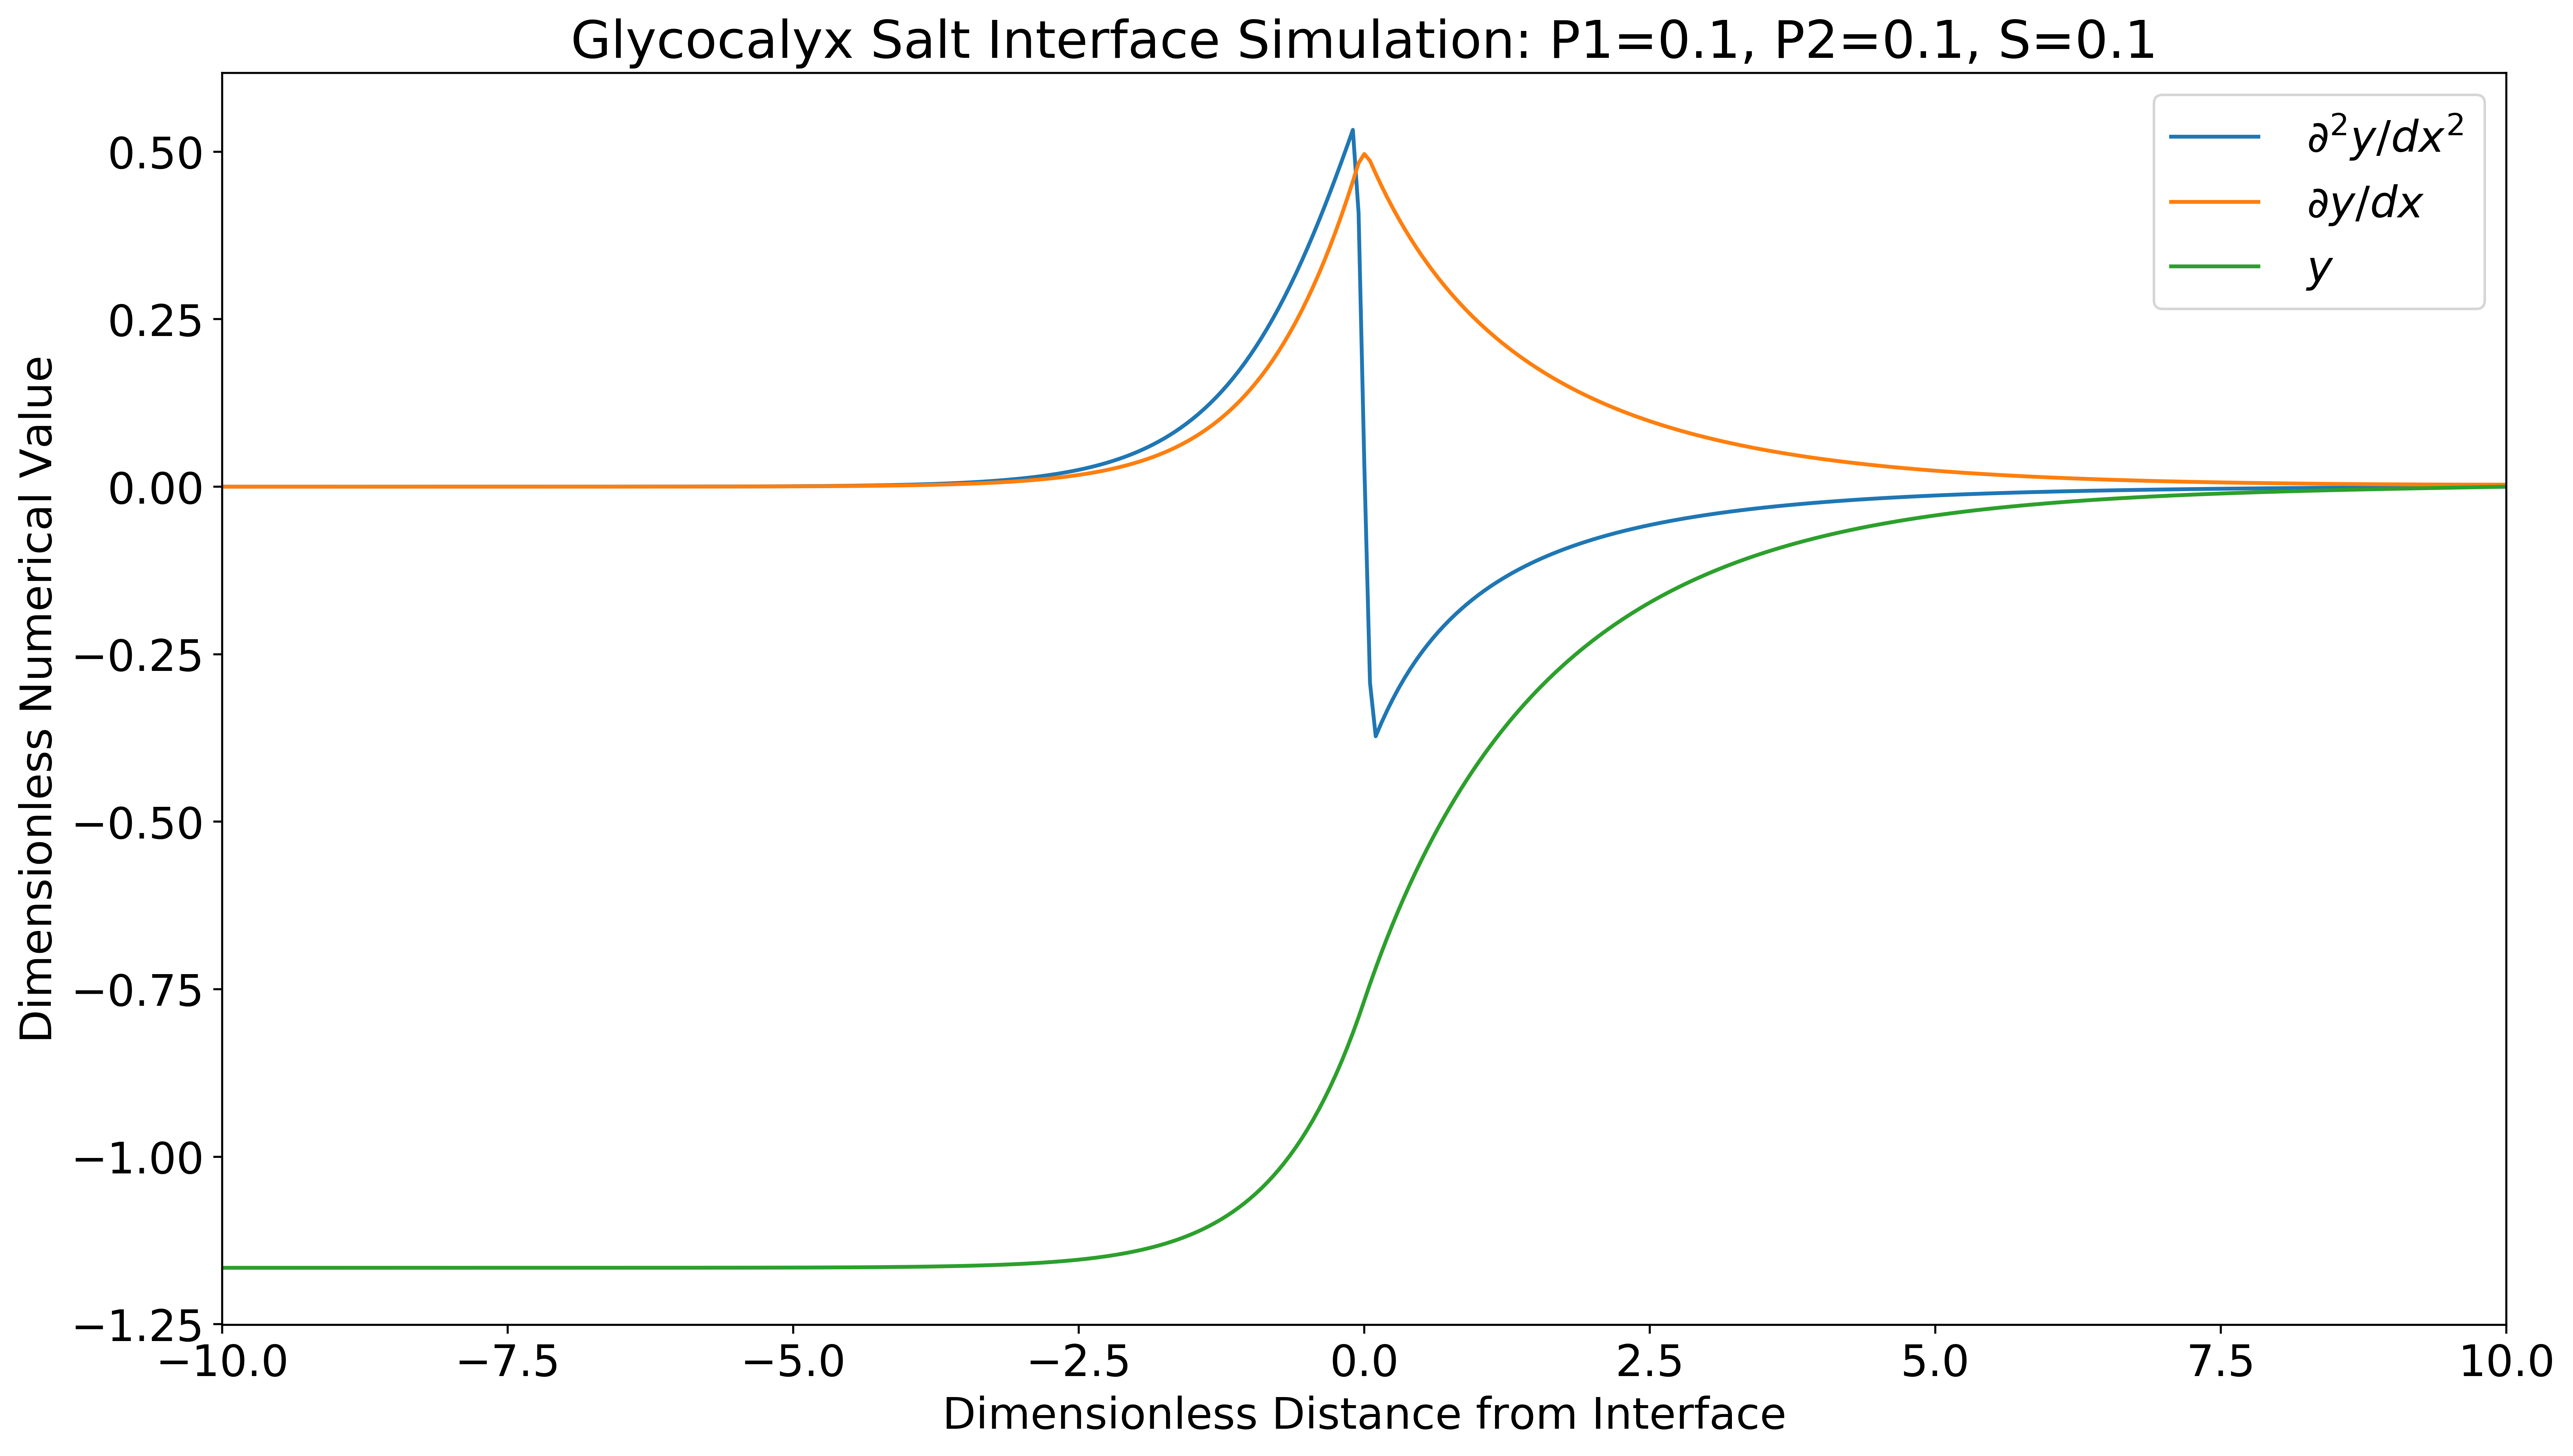

In [10]:
DonnanPrime = np.gradient(Donnan, dx, edge_order = 2)
DonnanDoublePrime = np.gradient(DonnanPrime, dx, edge_order =2)

plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(16,9), dpi=500)
plt.plot(testrange, DonnanDoublePrime, label=r" $\partial^2 y / dx^2$ ")
plt.plot(testrange, DonnanPrime, label = r" $\partial y / dx$ ")
plt.plot(testrange, Donnan, label = r" $y$ ")


plt.title('Glycocalyx Salt Interface Simulation: P1='+ str(P1) + ', P2=' + str(P2) + ', S=' + str(S))
plt.legend()
plt.xlabel('Dimensionless Distance from Interface')
plt.ylabel('Dimensionless Numerical Value')
plt.xlim(testrange[0], testrange[-1])
plt.savefig('steady state divalent derivs.jpg')